# Maximum Likelihood Method
---
This notebook should visualize aspects of different likelihood methods.
## Preparation

In [1]:
# Import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pprint
import scipy.integrate as integrate

# Set a random seed for the random number generator
rng = np.random.default_rng(seed=1)

# Set the style of the plots
sns.set_theme(context="talk", style="whitegrid")

## 1. Unbinned Logarithmic Likelihood

### Generate Pseudo-Data

For this example we generate $1.23\times 10^6$ events, which are normal distributed with a mean of 2 and a width of 1.

In [2]:
pseudo_data = rng.normal(loc=2, scale=1, size=int(1.23e6))
pprint.pp(pseudo_data)

array([2.34558419, 2.82161814, 2.33043708, ..., 0.63158501, 1.07802273,
       1.99481863], shape=(1230000,))


### Define the Model Probability Density Function

In general, the model probability density function (PDF) should describe the occurrence probability of a random variable $\vec{x}$ within a certain range $\Delta\vec{x}$. It should describe our data distribution and can also be dependent on model parameters $\vec{\theta}$.

In our case the model PDF is a normal distribution

$$p(x;\sigma,\mu)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

with the random variable $\vec{x}=x$ and model parameters $\vec{\theta}=(\sigma,\mu)^T$.

Now, we define the normal distribution.

In [3]:
def normal_pdf(x: float | np.ndarray, mu: float, sigma: float) -> float | np.ndarray:
    """
    Normal probability density function

    Args:
        x (float | np.ndarray): random variable
        mu (float): mean
        sigma (float): standard deviation

    Returns:
        float | np.ndarray: probability density for the given random variable
    """
    return (
        1 / (np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
    )

### Plot the Pseudo-Data and Model PDF

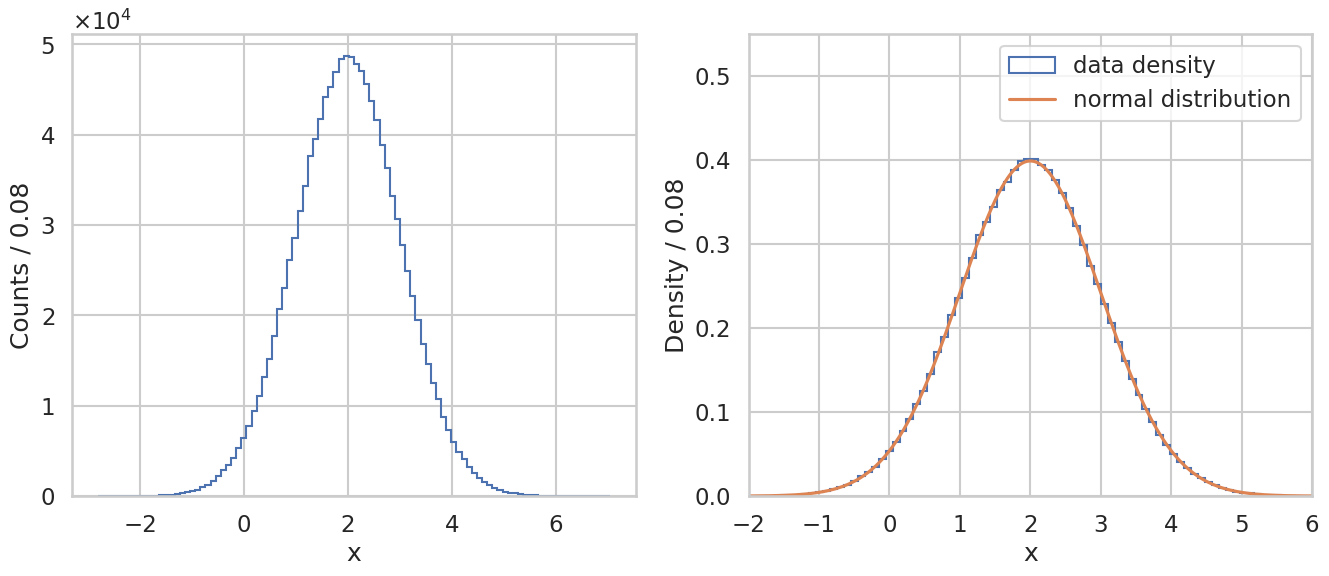

In [4]:
# Define the range of the random variable
x = np.linspace(start=-2, stop=6, num=1000)
# Calculate the probability density function for different values of the random variable
p = normal_pdf(x=x, mu=2, sigma=1)

# Define bin edges and get the bin width
bin_edges = np.linspace(start=-2, stop=6, num=101)
bin_width = bin_edges[1] - bin_edges[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the histogram of the pseudo data
ax[0].hist(x=pseudo_data, bins=100, histtype="step", label="pseudo data")
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].yaxis.get_major_formatter().set_powerlimits((0, 1))
ax[0].set_xlabel("x")
ax[0].set_ylabel(f"Counts / {bin_width:.2f}")

# Plot the density distribution of the pseudo data and the normal distribution
ax[1].hist(x=pseudo_data, bins=100, histtype="step", density=True, label="data density")
ax[1].plot(x, p, label="normal distribution")
ax[1].set_xlim(-2, 6)
ax[1].set_ylim(0, 0.55)
ax[1].set_xlabel("x")
ax[1].set_ylabel(f"Density / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

### Define the Negative Logarithmic Likelihood Function

The likelihood that a given set of **independent and identically distributed random variables** $\vec{x}$ is distributed according to a model PDF $f(\vec{x};\vec{\theta})$ is given as

$$ \mathcal{L}(\vec{x};\vec{\theta}) = \prod_{i=0}^{N_\text{data}} f(\vec{x}_i;\vec{\theta}). $$

Because multiplying multiple small values between 0 and 1 can lead to values that reach the numerical float limit, usually the logarithm of this function is used. And because one wants to maximize the likelihood to get the right model parameters, but most algorithms are written to minimize a function, one uses the negative logarithmic likelihood:

$$ -\ln{\mathcal{L}} = - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})}. $$

Lets define that function.

In [5]:
def neg_ln_L(pdf: float | np.ndarray) -> float:
    """
    Negative log-likelihood function

    Args:
        pdf (float | np.ndarray): probability density function

    Returns:
        float: negative log-likelihood
    """
    return -np.sum(np.log(pdf))

### Get the Likelihood of Different Model Parameters

We now want to see how the likelihood function changes for different model parameters. Let's first take a look at the parameters used to generate the data.

In [6]:
# Calculate the negative log-likelihood for the standard deviation and mean of the normal distribution used for the pseudo data
mu = 2
sigma = 1
model_L = neg_ln_L(normal_pdf(x=pseudo_data, mu=mu, sigma=sigma))
print("Negative log-likelihood:", model_L)

Negative log-likelihood: 1743709.8213917045


Now we implement a grind scan for different combinations of $\sigma$ and $\mu$ to see how the likelihood changes in the 2d parameter space

In [7]:
# Define the range of the mean and standard deviation for the grid scan
mu_scan = np.linspace(start=1, stop=3, num=21)
print("First 5 means:", mu_scan[:5])
sigma_scan = np.linspace(start=0.5, stop=1.5, num=21)
print("First 5 standard deviations:", sigma_scan[:5])

# Calculate the negative log-likelihood for the grid scan
neg_ln_L_scan = np.array(
    [
        [
            neg_ln_L(normal_pdf(x=pseudo_data, mu=mu, sigma=sigma))
            for sigma in sigma_scan
        ]
        for mu in mu_scan
    ]
)
print("First 5 negative log-likelihoods: ", neg_ln_L_scan[0][:5])

First 5 means: [1.  1.1 1.2 1.3 1.4]
First 5 standard deviations: [0.5  0.55 0.6  0.65 0.7 ]
First 5 negative log-likelihoods:  [5189636.87048079 4454387.53510058 3913029.92494831 3506889.10533665
 3197662.53455617]


Let's see for which parameters the maximum likelihood (minimum negative log likelihood) was achieved.

In [8]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_sigma = sigma_scan[best_i[1][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best sigma:", best_sigma)

Best negative log-likelihood: 1743709.8213917045
Best mu: 2.0
Best sigma: 1.0


We see that the best likelihood was achieved at our input parameters, which is the wanted result.

Now we want to plot the likelihood contours of the parameter space with the results of the grid scan.

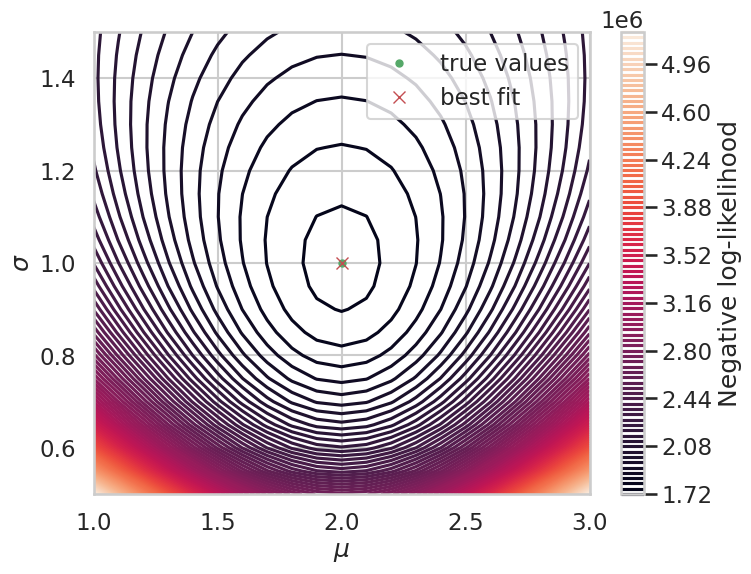

In [9]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax.contour(
    mu_scan,
    sigma_scan,
    neg_ln_L_scan.T,
    vmin=best_L,
    levels=100,
)

ax.plot(mu, sigma, marker="o", ls="", ms=5, color="g", label="true values")
ax.plot(best_mu, best_sigma, marker="x", ls="", color="r", label="best fit")
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
plt.colorbar(contour, ax=ax, label="Negative log-likelihood")
ax.legend()
plt.show()

We can see that the contours close in around the true model parameters and that the values seem to diverge for far away mean values.

## 2. Efficiency Correction

The data distributions that we can observe in reality will always be affected by an detection efficiency $\epsilon$, that may also be dependent on the random variable $\vec{x}$. Let's simulate a $x$ dependent efficiency with a linear function.

### Apply Efficiency on Data

We now want to apply an efficiency to our data sample. Let's simulate a $x$ dependent efficiency with a linear function.

In [10]:
def lin_eff(x: np.ndarray | float) -> float | np.ndarray:
    """
    Linear efficiency function defined from x=-3 to x=7. The efficiency is 0 for x < -3 and 1 for x > 7.

    Args:
        x (np.ndarray | float): random variable

    Returns:
        float | np.ndarray: efficiencies for the given random variable
    """
    xmin = -3
    xmax = 7
    return np.where(x < xmin, 0, np.where(x > xmax, 1, (x - xmin) / (xmax - xmin)))

Define a function that randomly removes elements from our data set dependent on our efficiency.

In [11]:
def apply_eff(sample: np.ndarray) -> np.ndarray:
    """
    Apply the efficiency to the sample

    Args:
        sample (np.ndarray): sample to apply the efficiency

    Returns:
        np.ndarray: sample with the efficiency applied
    """
    eff = lin_eff(sample)
    return sample[eff > rng.uniform(size=len(sample))]

Now create our new accepted data sample.

In [12]:
acc_data = apply_eff(pseudo_data)

### Plot the Data with the Applied Efficiency

bin width: 0.08000000000000007


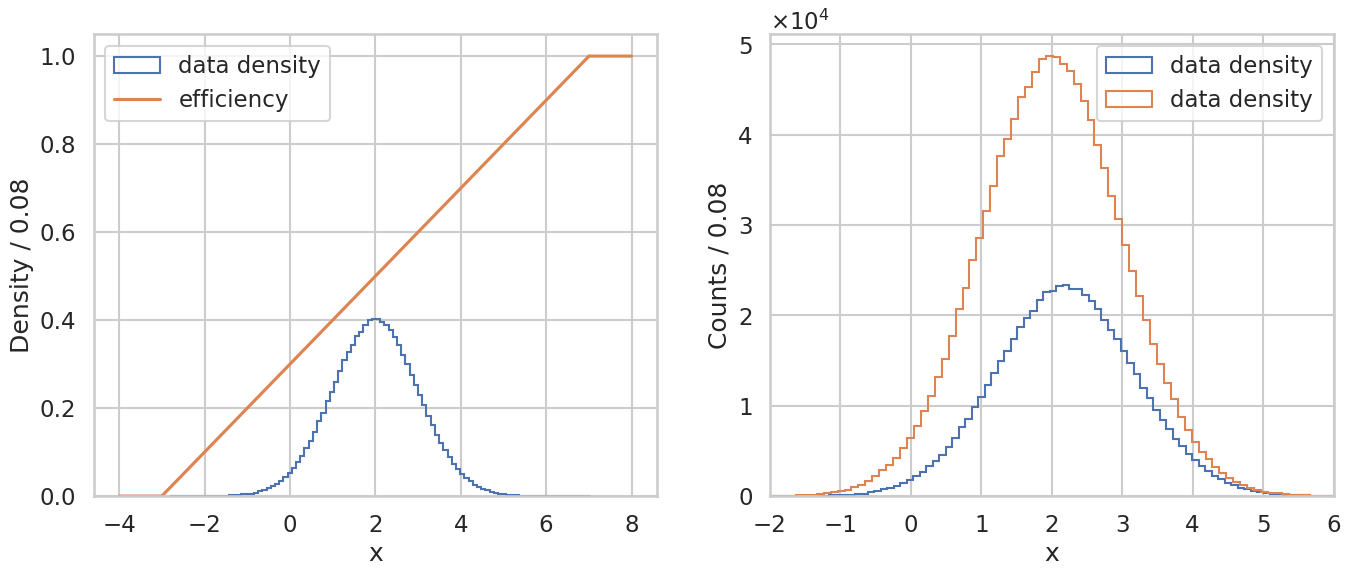

In [13]:
# Define the range of the random variable
x = np.linspace(start=-4, stop=8, num=1000)
# Calculate the efficiency for different values of the random variable
eff = lin_eff(x)

# Define bin edges and get the bin width
bin_edges = np.linspace(start=-2, stop=6, num=101)
bin_width = bin_edges[1] - bin_edges[0]
print("bin width:", bin_width)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the histogram of the pseudo data
ax[0].hist(x=pseudo_data, bins=100, histtype="step", density=True, label="data density")
ax[0].plot(x, eff, label="efficiency")
ax[0].set_xlabel("x")
ax[0].set_ylabel(f"Density / {bin_width:.2f}")
ax[0].legend()

# Plot the density distribution of the pseudo data and the normal distribution
ax[1].hist(x=acc_data, bins=100, histtype="step", label="data density")
ax[1].hist(x=pseudo_data, bins=100, histtype="step", label="data density")
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[1].yaxis.get_major_formatter().set_powerlimits((0, 1))
ax[1].set_ylabel(f"Counts / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

### Repeat the Likelihood Grid Scan

We can now repeat the grid search with the accepted data.

In [14]:
# Define the range of the mean and standard deviation for the grid search
mu_scan = np.linspace(start=1, stop=3, num=21)
sigma_scan = np.linspace(start=0.5, stop=1.5, num=21)

# Calculate the negative log-likelihood for the grid search
neg_ln_L_scan = np.array(
    [
        [neg_ln_L(normal_pdf(x=acc_data, mu=mu, sigma=sigma)) for sigma in sigma_scan]
        for mu in mu_scan
    ]
)

Best negative log-likelihood: 860182.8660164559
Best mu: 2.2
Best sigma: 1.0


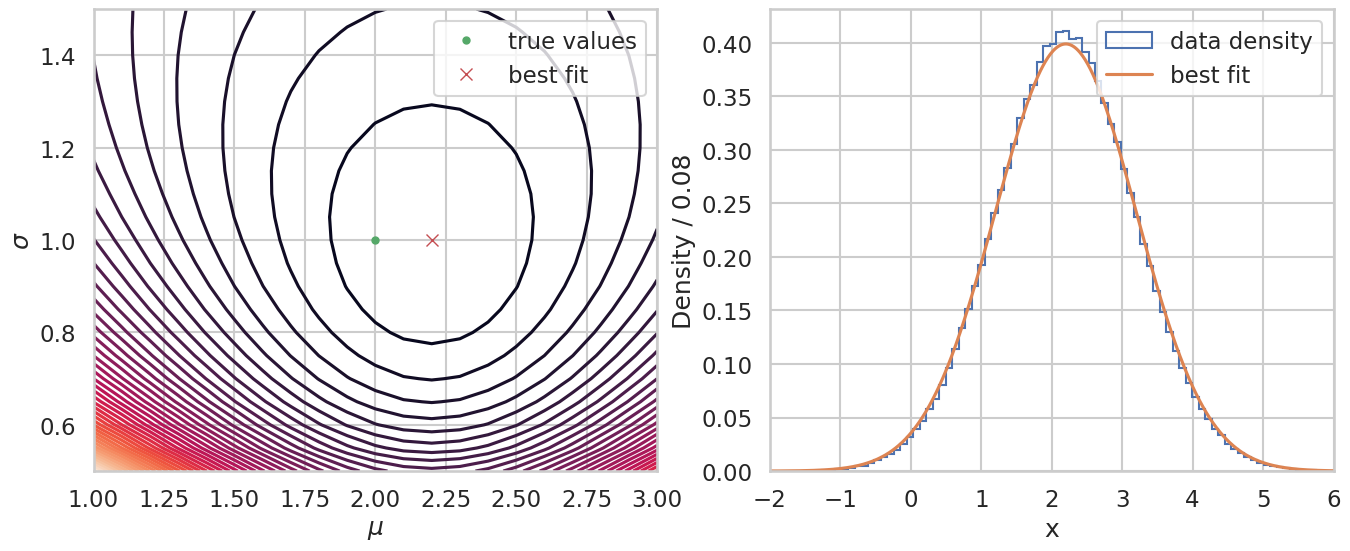

In [15]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_sigma = sigma_scan[best_i[1][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best sigma:", best_sigma)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax[0].contour(
    mu_scan,
    sigma_scan,
    neg_ln_L_scan.T,
    levels=50,
)
ax[0].plot(mu, sigma, marker="o", ls="", ms=5, color="g", label="true values")
ax[0].plot(best_mu, best_sigma, marker="x", ls="", color="r", label="best fit")
ax[0].set_xlabel("$\mu$")
ax[0].set_ylabel("$\sigma$")
ax[0].legend()

ax[1].hist(x=acc_data, bins=100, histtype="step", density=True, label="data density")
ax[1].plot(x, normal_pdf(x, mu=best_mu, sigma=best_sigma), label="best fit")
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].set_ylabel(f"Density / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

We can see that the model parameters with the minimum likelihood describe the accepted data well, even though they are not the parameters with which they were generated. This is the case because our current model does not consider the efficiency.

Next we want to redefine our model PDF to include the efficiency information.

### Efficiency Corrected Model PDF & negative Log-Likelihood

In the most ideal (but unrealistic) case we know the efficiency factor $\epsilon(\vec{x})$. In this case we just need to correct our model PDF and apply a new normalization as follows,

$$ F(\vec{x};\vec{\theta})=\frac{f(\vec{x};\vec{\theta})\epsilon(\vec{x})}{\int f(\vec{x};\vec{\theta})\epsilon(\vec{x}) \text{d}x}.$$

The integral for the normalization has to cover the entire phase space of $\vec{x}$, however, because we know that our efficiency is 0 outside of [-3,7], we can use these values as our integration limits. 

So let's define our new PDF.

In [16]:
def normal_pdf_eff(
    x: float | np.ndarray, mu: float, sigma: float
) -> float | np.ndarray:
    """
    Normalized normal distribution with an efficiency factor

    Args:
        x (float | np.ndarray): random variable
        mu (float): mean of the normal distribution
        sigma (float): standard deviation of the normal distribution

    Returns:
        float | np.ndarray: probability density for the given random variable
    """
    return (
        normal_pdf(x=x, mu=mu, sigma=sigma)
        * lin_eff(x)
        / (integrate.quad(lambda x: normal_pdf(x, mu, sigma) * lin_eff(x), -3, 7)[0])
    )

We can also define a new negative log-likelihood by using the logarithm laws:

$$ -\ln{\mathcal{L}} = - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})} - \sum_{i=0}^{N_\text{data}}\ln{\epsilon(\vec{x}_i)} + N_\text{data} \cdot \ln{\left(\int f(\vec{x};\vec{\theta}) \epsilon(\vec{x}) \text{d}x\right)}.$$

The fact that $\epsilon(\vec{x})$ is independent from our model parameters means that the summand, which only contains the efficiency, becomes a constant and can be ignored if we search for the minimum negative log-likelihood.

$$ -\ln{\mathcal{L}} = - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})} + N_\text{data}\cdot\ln{\left(\int f(\vec{x};\vec{\theta}) \epsilon(\vec{x}) \text{d}x\right)} + \text{const.}$$

Let's repeat the likelihood grid scan again (redefining the likelihood function here as seen above is not necessary at this step).

In [17]:
# Define the range of the mean and standard deviation for the grid search
mu_scan = np.linspace(start=1, stop=3, num=21)
sigma_scan = np.linspace(start=0.5, stop=1.5, num=21)

# Calculate the negative log-likelihood for the grid search
neg_ln_L_scan = np.array(
    [
        [
            neg_ln_L(normal_pdf_eff(x=acc_data, mu=mu, sigma=sigma))
            for sigma in sigma_scan
        ]
        for mu in mu_scan
    ]
)

Best negative log-likelihood: 859875.9849003886
Best mu: 2.0
Best sigma: 1.0


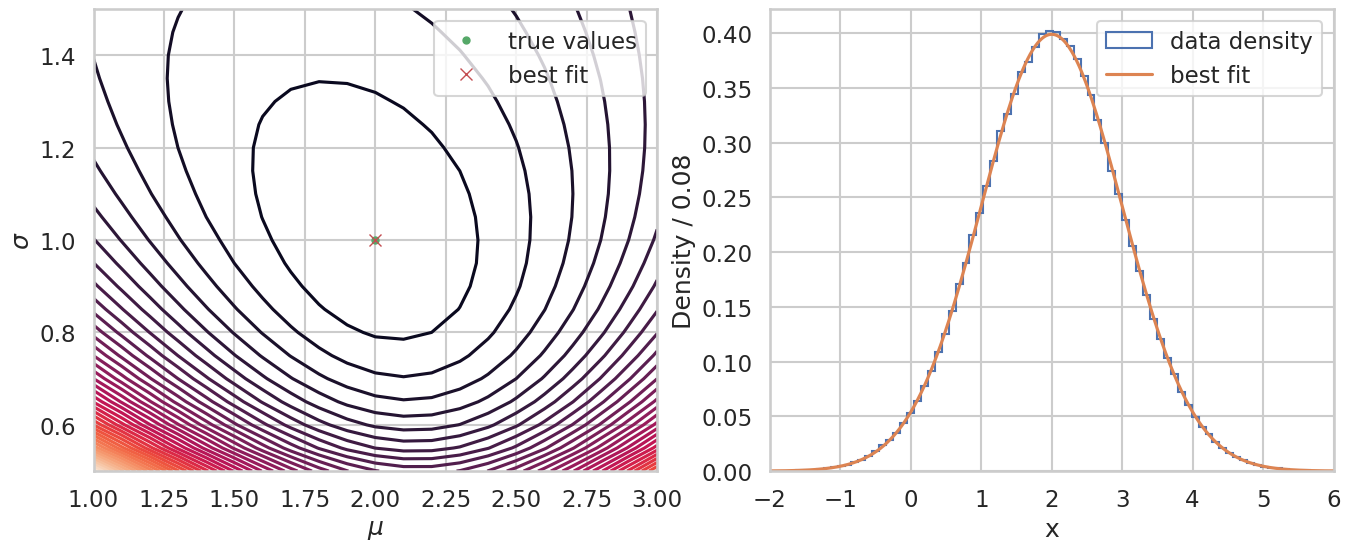

In [18]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_sigma = sigma_scan[best_i[1][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best sigma:", best_sigma)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax[0].contour(
    mu_scan,
    sigma_scan,
    neg_ln_L_scan.T,
    levels=50,
)
ax[0].plot(mu, sigma, marker="o", ls="", ms=5, color="g", label="true values")
ax[0].plot(best_mu, best_sigma, marker="x", ls="", color="r", label="best fit")
ax[0].set_xlabel("$\mu$")
ax[0].set_ylabel("$\sigma$")
ax[0].legend()

ax[1].hist(x=pseudo_data, bins=100, histtype="step", density=True, label="data density")
ax[1].plot(x, normal_pdf(x, mu=best_mu, sigma=best_sigma), label="best fit")
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].set_ylabel(f"Density / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

We can see that the new model now gives us again our true model parameters and describes the accepted data density distribution well.

### Efficiency Approximation with Simulations

In most cases we do not know our efficiency distribution and thus cannot use the previous method. Instead one can use the [Monte Carlo integration method](https://www.cambridge.org/core/journals/acta-numerica/article/monte-carlo-and-quasimonte-carlo-methods/FE7C779B350CFEA45DB2A4CCB2DA9B5C#), exploiting the relation that the integral $I$ of a Lebesgue integrable function $f$ can be expressed as the expectation value of $f$ at a random location $x$ in a n-dimensional phase space $\Omega^n$:

$$ I[f] = \int_{\Omega^n} f(\vec{x}) \text{d}x = \bar{f}, $$

with the phase space volume $V$ being defined as:

$$ V=\int_{\Omega^n}dx. $$

Now we can use the empirical approximation of the expectation value for a sequence $ {x_i} $ sampled from $\Omega^n$:

$$ \bar{f}_N = \frac{V}{N}\sum^N_{i=0} f(x_i), $$

which converges towards $\bar{f_N}\to\bar{f}$ for $N\to\infty$. Using this relation we can now approximate the integral using a phase space generated Monte Carlo sample:

$$ \int_\Omega f(\vec{x};\vec{\theta}) \epsilon(\vec{x}) \text{d}x = \frac{V}{N_\text{gen}} \sum_{i=0}^{N_\text{gen}}f(\vec{x}_i;\vec{\theta})\epsilon(\vec{x}). $$

I we now assume that our efficiency is a binary function, that is either 0 for a rejected value of $x$, or 1 for an accepted value, we can substitute the sum over the generated MC with the accepted one and remove the efficiency function:

$$ \int_\Omega f(\vec{x};\vec{\theta}) \epsilon(\vec{x}) \text{d}x = \frac{V}{N_\text{gen}} \sum_{i=0}^{N_\text{acc}}f(\vec{x}_i;\vec{\theta}). $$

resulting in the new likelihood relation:

$$ -\ln{\mathcal{L}} = - \sum_{i=0}^{N_\text{data}}\ln{f(\vec{x}_i;\vec{\theta})} + N_\text{data} \cdot \ln{\left(\sum_{j=0}^{N_\text{acc}}f(\vec{x}_j;\vec{\theta})\right)} + \text{const.} $$

Note that the factor $V/N_\text{gen}$, or more specifically $N_\text{data}\cdot\ln{\left(V/N_\text{gen}\right)}$, gets absorbed into the constant part in the end.
Now we define the new likelihood function.

In [19]:
def neg_ln_L_eff(pdf_data: float | np.ndarray, pdf_sim: float | np.ndarray) -> float:
    """
    Negative log-likelihood function with an efficiency correction estimated with accepted simulation data.

    Args:
        pdf_data (float | np.ndarray): Probabilities of the data according to the model
        pdf_sim (float | np.ndarray): Probabilities of the simulation according to the model

    Returns:
        float: negative log-likelihood
    """
    return -np.sum(np.log(pdf_data)) + len(pdf_data) * np.log(np.sum(pdf_sim))

To use this definition we need to simulate an efficiency accepted sample. For that, we generate a uniform distribution of $10^8$ events between $x=-4$ and $x=8$, giving us a phase space volume of $V=12$, to cover a good part of the phase space that we are scanning. It should be noted that in theory the phase space of the normal distribution is infinitely large, meaning that if we would scan for higher means or standard deviations, the phase space volume of the Monte Carlo simulation has to be increased accordingly. After we generate the sample, the same efficiency function is applied onto the sample.

In [61]:
# simulate an even distribution from -4 to 8
x_min = -5
x_max = 9
V = x_max - x_min
sim_data = rng.uniform(low=x_min, high=x_max, size=int(2e8))

# Apply the efficiency to the simulated data
sim_acc_data = apply_eff(sim_data)

Now let's take a look at the samples we have generated.

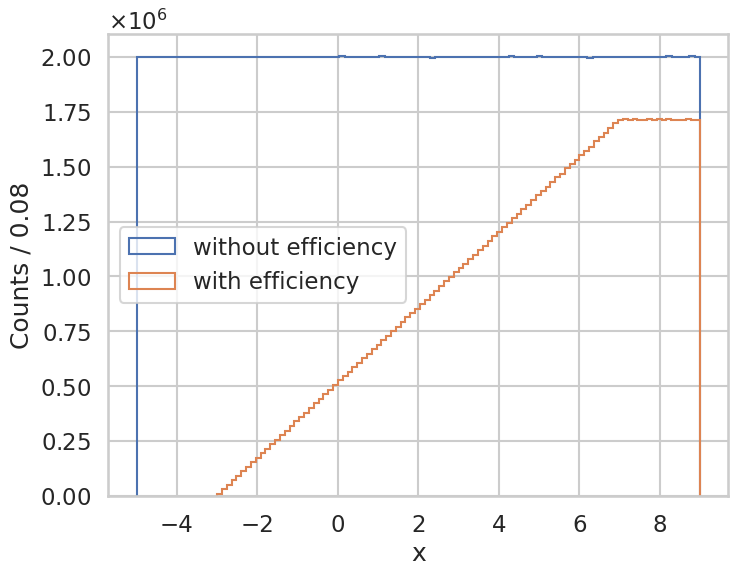

In [62]:
# Define bin edges and get the bin width
bin_edges = np.linspace(start=-2, stop=6, num=101)
bin_width = bin_edges[1] - bin_edges[0]

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram of the pseudo data
ax.hist(x=sim_data, bins=100, histtype="step", label="without efficiency")
ax.hist(x=sim_acc_data, bins=100, histtype="step", label="with efficiency")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
ax.set_xlabel("x")
ax.set_ylabel(f"Counts / {bin_width:.2f}")
ax.legend()

plt.show()

Now we can use the simulations to again make a likelihood scan.

In [22]:
# Define the range of the mean and standard deviation for the grid search
mu_scan = np.linspace(start=1, stop=3, num=21)
sigma_scan = np.linspace(start=0.5, stop=1.5, num=21)

# Calculate the negative log-likelihood for the grid search
neg_ln_L_scan = np.array(
    [
        [
            neg_ln_L_eff(
                normal_pdf(x=acc_data, mu=mu, sigma=sigma),
                normal_pdf(x=sim_acc_data, mu=mu, sigma=sigma),
            )
            for sigma in sigma_scan
        ]
        for mu in mu_scan
    ]
)

And then plot the results. This time we plot the density of the simulated accepted data with weights determined by our model PDF with the best model parameters according to the likelihood scan.

Best negative log-likelihood: 10160089.394786438
Best mu: 2.0
Best sigma: 1.0


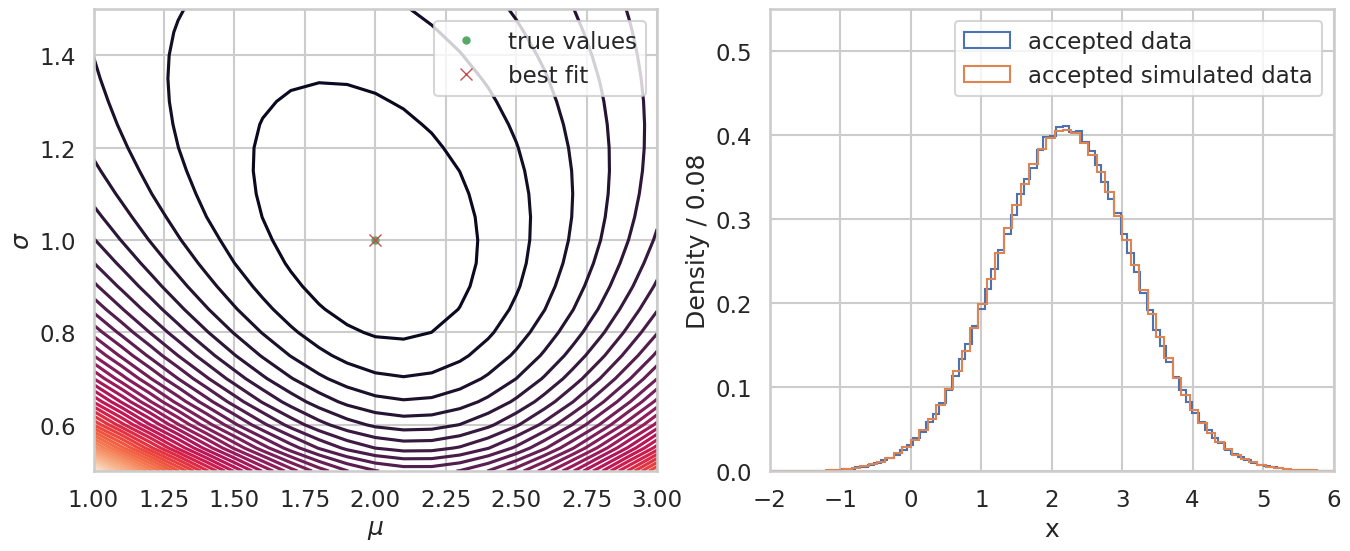

In [23]:
best_L = np.min(neg_ln_L_scan)
best_i = np.where(neg_ln_L_scan == best_L)
best_mu = mu_scan[best_i[0][0]]
best_sigma = sigma_scan[best_i[1][0]]
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best sigma:", best_sigma)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
grid = np.meshgrid(mu_scan, sigma_scan)
contour = ax[0].contour(
    mu_scan,
    sigma_scan,
    neg_ln_L_scan.T,
    levels=50,
)
ax[0].plot(mu, sigma, marker="o", ls="", ms=5, color="g", label="true values")
ax[0].plot(best_mu, best_sigma, marker="x", ls="", color="r", label="best fit")
ax[0].set_xlabel("$\mu$")
ax[0].set_ylabel("$\sigma$")
ax[0].legend()

ax[1].hist(x=acc_data, bins=100, histtype="step", density=True, label="accepted data")
ax[1].hist(
    x=sim_acc_data,
    weights=normal_pdf(sim_acc_data, best_mu, best_sigma),
    density=True,
    bins=100,
    histtype="step",
    label="accepted simulated data",
)
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].set_ylim(0, 0.55)
ax[1].set_ylabel(f"Density / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()

We can again find our model parameters with the likelihood scan without even knowing the explicit efficiency function, and we can directly compare the fit result to our accepted data.

## 3. Extended Likelihood

With our current model, we only look at data densities at different points in the phase space of $\vec{x}$. However, often also the absolute number of events predicted by a model $N_\text{model}(\vec{\theta})$ is of interest. To do so, we assume that $N_\text{model}$ is the mean value of a Poisson distribution, and is defined by the already established integral 

$$ N_\text{model}(\vec{\theta}) = \int f(\vec{x};\vec{\theta}) \epsilon(\vec{x}) \text{d}x = \frac{V}{N_\text{gen}} \sum_{i=0}^{N_\text{acc}}f(\vec{x}_i;\vec{\theta}). $$

The likelihood function is then defined as

$$ \mathcal{L} = \frac{N_\text{model}(\vec{\theta})^{N_\text{data}}}{N_\text{data}!}e^{-N_\text{model}(\vec{\theta})}\prod_{i=0}^{N_\text{data}} \frac{f(\vec{x};\vec{\theta}) \epsilon(\vec{x})}{N_\text{model}(\vec{\theta})}.$$

And the negative log-likelihood is defined as

$$ -\ln{\mathcal{L}} = -\left[N_\text{data}\ln{\left(N_\text{model}(\vec{\theta})\right)} - \ln{\left(N_\text{data}!\right)} - N_\text{model}(\vec{\theta}) + \sum_{i=0}^{N_\text{data}}\ln{\left(f(\vec{x};\vec{\theta})\right)} - N_\text{data}\ln{\left(\epsilon(\vec{x})\right)} - N_\text{data}\ln{\left(N_\text{model}(\vec{\theta})\right)} \right], $$

which reduces to

$$ -\ln{\mathcal{L}} = \frac{V}{N_\text{gen}} \sum_{i=0}^{N_\text{acc}}f(\vec{x}_i;\vec{\theta}) - \sum_{i=0}^{N_\text{data}}\ln{\left(f(\vec{x};\vec{\theta})\right)}. $$

So let's define this new extended likelihood:

In [24]:
def ext_neg_ln_L(
    pdf_data: float | np.ndarray, pdf_sim: float | np.ndarray, gen_sim: int, V: float
) -> float:
    """
    Extended negative log-likelihood function with an efficiency correction estimated with accepted simulation data.

    Args:
        pdf_data (float | np.ndarray): Probabilities of the data according to the model
        pdf_sim (float | np.ndarray): Probabilities of the simulation according to the model
        gen_sim (int): Number of generated simulation data
        V (float): Volume of the phase space

    Returns:
        float: negative log-likelihood
    """
    return -np.sum(np.log(pdf_data)) + V / gen_sim * np.sum(pdf_sim)

To make this approach work we of cause have to introduce a parameter that is proportional to the number of events into our model. In our case, we can just multiply a scale factor $N$ to our normalized normal distribution:

In [25]:
def normal_distribution(
    x: float | np.ndarray, mu: float, sigma: float, N: float
) -> float | np.ndarray:
    """
    Normal distribution of N measurements.

    Args:
        x (float | np.ndarray): random variable
        mu (float): mean
        sigma (float): standard deviation
        N (float): number of measurements

    Returns:
        float | np.ndarray: number of events for the given random variable
    """
    return (
        N / (np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
    )

To reduce the number of parameters that we include in our scan, we will say, that we already know the mean and standard deviation of our normal distribution, but not, how much was data was produced, aka $N$. To get an estimate we will do a 1d likelihood scan for different parameters $N$. First we will test how our previously defined likelihood function handles the new parameter.

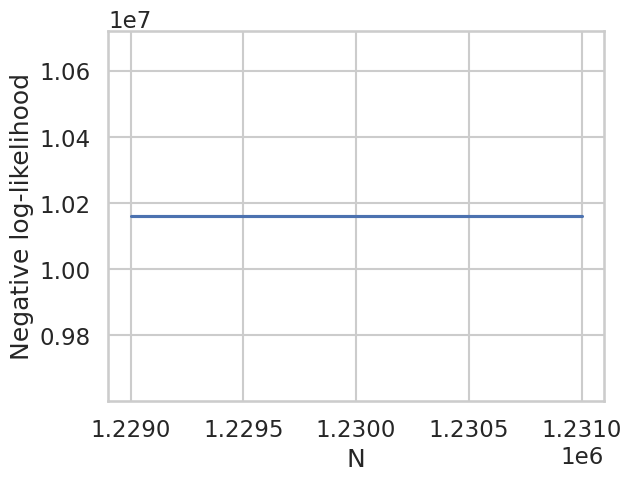

In [26]:
N_data = len(pseudo_data)
N_scan = np.linspace(
    start=N_data - 1e3, stop=N_data + 1e3, num=21
)
neg_ln_L_vals = [
    neg_ln_L_eff(
        normal_distribution(x=acc_data, mu=2, sigma=1, N=n),
        normal_distribution(x=sim_acc_data, mu=2, sigma=1, N=n),
    )
    for n in N_scan
]
plt.plot(N_scan, neg_ln_L_vals)
plt.xlabel("N")
plt.ylabel("Negative log-likelihood")
plt.show()

As expected, the likelihood distribution is completely flat, meaning that the parameter $N$ cannot be determined with this method. This makes sense, as its effectively canceled out by the normalization, if one considers $f' = N\cdot f$:

$$ F(\vec{x};\vec{\theta})=\frac{f'(\vec{x};\vec{\theta})\epsilon(\vec{x})}{\int f'(\vec{x};\vec{\theta})\epsilon(\vec{x}) \text{d}x} = \frac{N\cdot f(\vec{x};\vec{\theta})\epsilon(\vec{x})}{\int N\cdot f(\vec{x};\vec{\theta})\epsilon(\vec{x}) \text{d}x} = \frac{f(\vec{x};\vec{\theta})\epsilon(\vec{x})}{\int f(\vec{x};\vec{\theta})\epsilon(\vec{x}) \text{d}x}. $$

With the extended likelihood however, this is not the case anymore, so let's look how the same scan looks like with the new method:

In [63]:
N_scan = np.linspace(start=N_data - 1e4, stop=N_data + 1e4, num=21)
neg_ln_L_vals = [
    ext_neg_ln_L(
        normal_distribution(x=acc_data, mu=2, sigma=1, N=n),
        normal_distribution(x=sim_acc_data, mu=2, sigma=1, N=n),
        len(sim_data),
        V,
    )
    for n in N_scan
]

Best negative log-likelihood: -7144454.954850696
Best mu: 2
Best N: 1231000.0
True N: 1230000


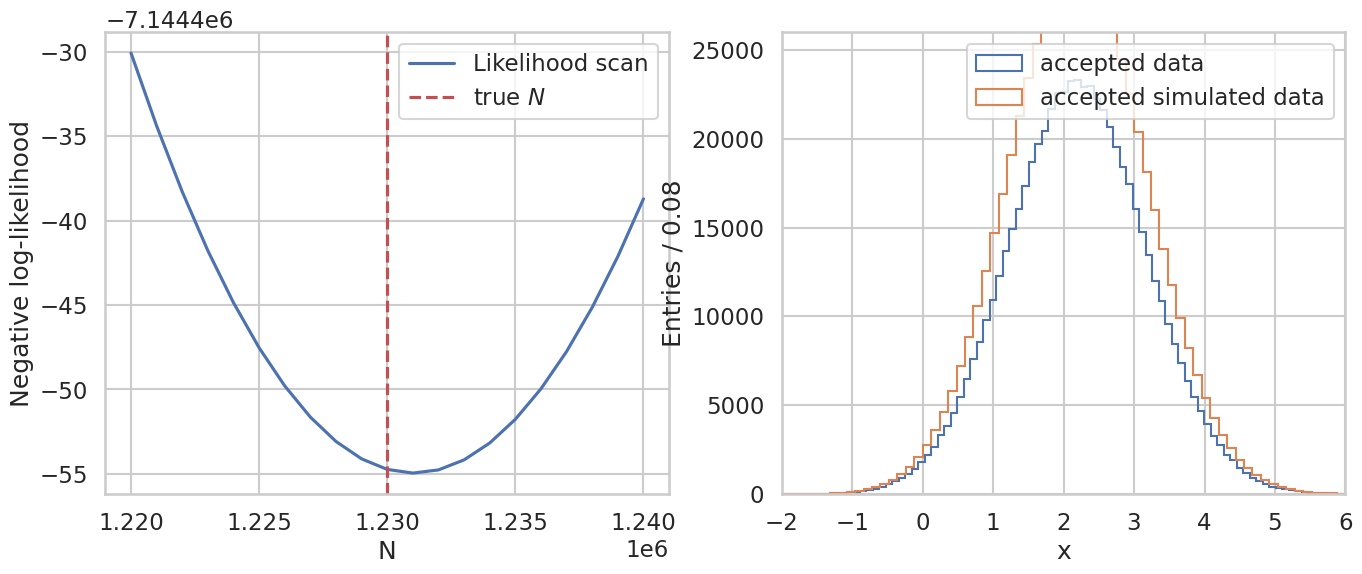

In [64]:
best_L = np.min(neg_ln_L_vals)
best_i = np.where(neg_ln_L_vals == best_L)
best_N = N_scan[best_i[0][0]]
best_mu = 2
best_sigma = 1
print("Best negative log-likelihood:", best_L)
print("Best mu:", best_mu)
print("Best N:", best_N)
print("True N:", len(pseudo_data))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(N_scan, neg_ln_L_vals, label="Likelihood scan")
ax[0].axvline(x=len(pseudo_data), color="r", ls="--", label="true $N$")
ax[0].set_xlabel("N")
ax[0].set_ylabel("Negative log-likelihood")
ax[0].legend()
ax[1].hist(x=acc_data, bins=100, histtype="step", label="accepted data")
ax[1].hist(
    x=sim_acc_data,
    weights=normal_distribution(sim_acc_data, best_mu, best_sigma, best_N)
    / np.sum(normal_distribution(sim_acc_data, best_mu, best_sigma, best_N))
    * len(acc_data),
    bins=100,
    histtype="step",
    label="accepted simulated data",
)
ax[1].set_xlim(-2, 6)
ax[1].set_xlabel("x")
ax[1].set_ylim(0, 2.6e4)
ax[1].set_ylabel(f"Entries / {bin_width:.2f}")
ax[1].legend(loc="upper right")
plt.show()